
LightGBM Evaluation:
  ACC:0.83
  Precision:1.00
  Recall:0.78
  F1:0.88
  AUC:0.85


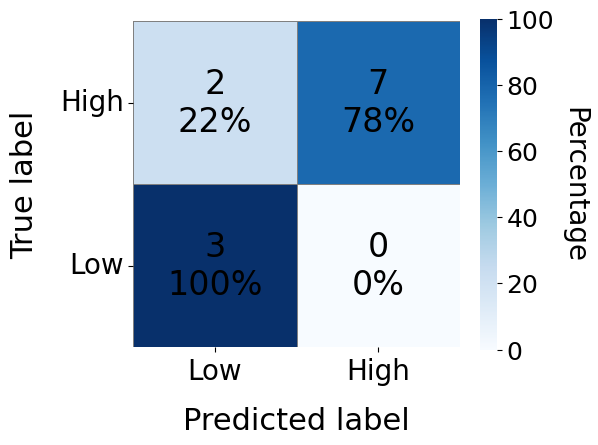

(0.8333333333333334,
 1.0,
 0.7777777777777778,
 0.8750000000000001,
 0.8518518518518519)

In [4]:
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# load Data
df2 = pd.read_csv(r'Data/Train/H2_production_rate_target.csv')
df3 = pd.read_csv(r"Data/Validation/vali_data.csv")
df3 = df3.loc[:, ~df3.columns.str.contains('^Unnamed')]
df4 = pd.read_csv(r'Data/Validation/H2_production_rate_target_vali.csv')

# load model
selected_features = joblib.load(r'Model/feature_selector.pkl')
lightgbm_model = joblib.load(r'Model/lightgbm_best_model.pkl')  
scaler_full = joblib.load(r'Model/scaler.pkl')  

percentile_65 = df2["H2_production_rate"].quantile(0.65)  
y_vali = np.where(df4["H2_production_rate"] < percentile_65, 0, 1)  

# select features
X_vali = df3[selected_features]
X_vali_selected = X_vali[selected_features] 
#select the same features
X_vali_scaled = scaler_full.transform(X_vali_selected)

#predict using LightGBM classifier

y_pred_lightgbm = lightgbm_model.predict(X_vali_scaled)
y_proba_lightgbm = lightgbm_model.predict_proba(X_vali_scaled)[:, 1]


def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"\n{model_name} Evaluation:")
    print(f"  ACC:{accuracy_score(y_true, y_pred):.2f}")
    print(f"  Precision:{precision_score(y_true, y_pred):.2f}")
    print(f"  Recall:{recall_score(y_true, y_pred):.2f}")
    print(f"  F1:{f1_score(y_true, y_pred):.2f}")
    print(f"  AUC:{roc_auc_score(y_true, y_proba):.2f}")

    cm = confusion_matrix(y_true, y_pred)
    cm_percent = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100)
    cm_display = [[f"{int(cm[j, k])}\n{int(cm_percent[j, k])}%" for k in range(cm.shape[1])] for j in range(cm.shape[0])]

    plt.figure(figsize=(6, 5))  

    ax = sns.heatmap(
    cm_percent, 
    annot=cm_display, 
    fmt='', 
    cmap='Blues',
    xticklabels=["Low", "High"], 
    yticklabels=["Low", "High"],
    cbar_kws={'label': 'Percentage', 'shrink': 0.85},  
    annot_kws={"size": 24, "color": "black"}, 
    square=True, 
    vmin=0, 
    vmax=100,
    linewidths=0.5,  
    linecolor='grey'  
)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=20, rotation=0)  
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=20, rotation=0)
    ax.set_xlabel('Predicted label', fontsize=22, labelpad=15)
    ax.set_ylabel('True label', fontsize=22, labelpad=15)
    cbar = ax.collections[-1].colorbar
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label('Percentage', size=20, rotation=-90, labelpad=25)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

    return accuracy_score(y_true, y_pred), precision_score(y_true, y_pred), recall_score(y_true, y_pred), f1_score(y_true, y_pred), roc_auc_score(y_true, y_proba)

evaluate_model(y_vali, y_pred_lightgbm, y_proba_lightgbm, 'LightGBM')
